In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing required libraries

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

## Extracting Dataset

In [5]:
!unzip '/content/drive/MyDrive/Rail Track Fault Detection/archive.zip' #unzipping dataset

Archive:  /content/drive/MyDrive/Rail Track Fault Detection/archive.zip
   creating: Railway Track fault Detection Updated/
   creating: Railway Track fault Detection Updated/Test/
   creating: Railway Track fault Detection Updated/Test/Defective/
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_100159.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_100209.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_101124.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_101200.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102203.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102222.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102819.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_103110.jpg  
  inflating: Rai

In [6]:
# Defining dataset paths
train_path = '/content/Railway Track fault Detection Updated/Train'
valid_path = '/content/Railway Track fault Detection Updated/Validation'
test_path = '/content/Railway Track fault Detection Updated/Test'

## Visualizing Data Samples

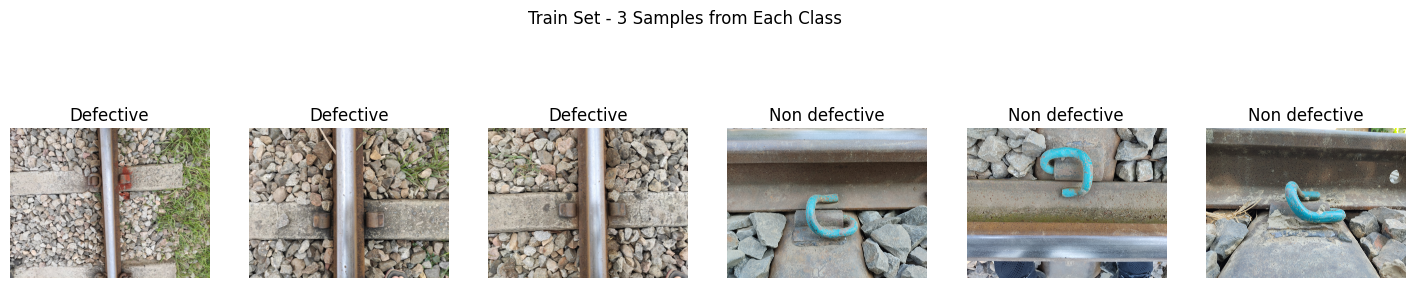

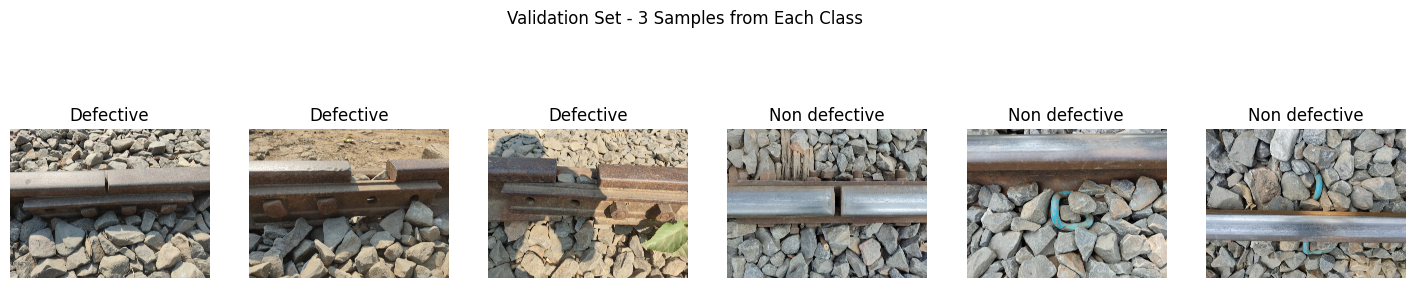

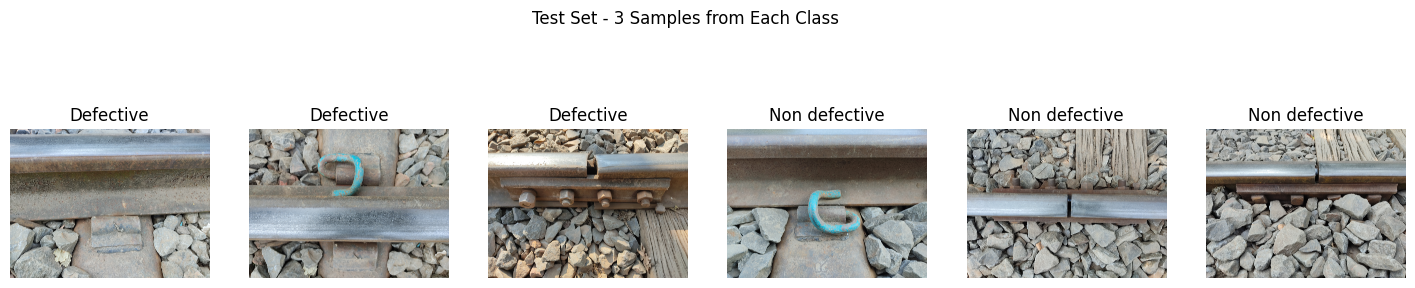

In [7]:
def show_sample_images(data_path, set_name):
    classes = sorted(os.listdir(data_path))  # ensure consistent order
    assert len(classes) == 2, "Expected exactly 2 classes"

    images_per_class = 3
    all_imgs = []

    for cls in classes:
        cls_path = os.path.join(data_path, cls)
        image_files = sorted(os.listdir(cls_path))[:images_per_class]
        cls_images = [os.path.join(cls_path, img) for img in image_files]
        all_imgs.extend((img_path, cls) for img_path in cls_images)

    # Plot all 6 images (3 from each class)
    plt.figure(figsize=(18, 4))
    for i, (img_path, label) in enumerate(all_imgs):
        img = mpimg.imread(img_path)
        plt.subplot(1, 6, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.suptitle(f'{set_name} Set - 3 Samples from Each Class')
    plt.show()

# Visualize samples from each dataset split
show_sample_images(train_path, "Train")
show_sample_images(valid_path, "Validation")
show_sample_images(test_path, "Test")


# 1) CNN Model

## Preprocessing

In [8]:
img_height, img_width = 150, 150
batch_size = 16
epochs = 100

# Augment training data to avoid overfitting
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Only rescale validation and test set
val_test_datagen = ImageDataGenerator(rescale=1./255)



### Creating generators for train, validation, and test sets

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)


Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [10]:
# Displaying class mappings
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

{'Defective': 0, 'Non defective': 1}
{'Defective': 0, 'Non defective': 1}
{'Defective': 0, 'Non defective': 1}


## Building and Training Model

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),   # Dropout to prevent overfitting
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,377 (18.42 MB)

 Trainable params: 4,828,929 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

## Compiling and Training the Model

In [12]:
# Compiling the Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# Training the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.4994 - loss: 1.8045 - val_accuracy: 0.5000 - val_loss: 0.8171
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.6636 - loss: 0.8037 - val_accuracy: 0.5000 - val_loss: 1.1823
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6744 - loss: 0.5841 - val_accuracy: 0.5000 - val_loss: 1.8031
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.6980 - loss: 0.6298 - val_accuracy: 0.5000 - val_loss: 2.1199
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7509 - loss: 0.5105 - val_accuracy: 0.5000 - val_loss: 2.3034
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7215 - loss: 0.5532 - val_accuracy: 0.5000 - val_loss: 3.0604
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7594 - loss: 0.5061 - val_accuracy: 0.5000 - val_loss: 2.1402
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7918 - loss: 0.4565 - val_accuracy: 0.5000 - v

## Plotting Training & Validation Accuracy and Loss

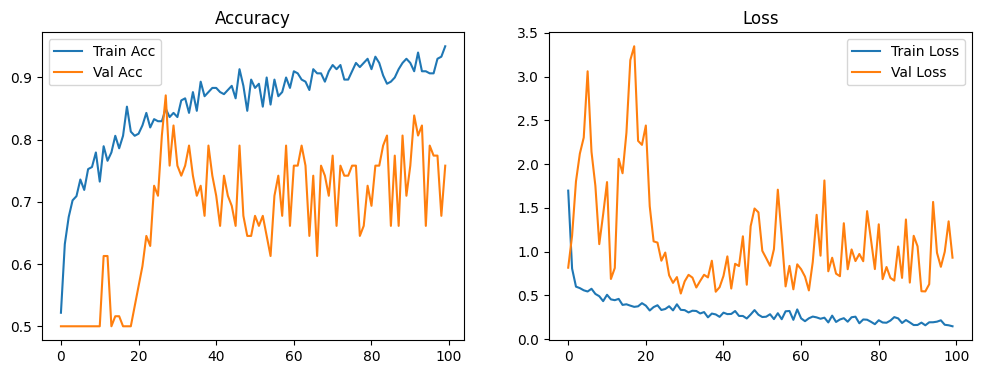

In [14]:
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Model Evaluation on Test Set

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

# Predicting classes for test data
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

# Printing classification report
print(classification_report(y_true, y_pred, target_names=['Defective', 'Non Defective'
                                                          ]))

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9130 - loss: 0.3046
Test Accuracy: 0.8636363744735718
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step
               precision    recall  f1-score   support

    Defective       0.83      0.91      0.87        11
Non Defective       0.90      0.82      0.86        11

     accuracy                           0.86        22
    macro avg       0.87      0.86      0.86        22
 weighted avg       0.87      0.86      0.86        22



## Prediction Using Model

In [20]:
# Define class names (adjust if needed)
class_names = ['Defective', 'Non Defective']

# Prediction function
def predict_image(model, img_path, target_size=(150, 150)):
    # Load and preprocess the image
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # normalize if used during training
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)

    # Decoding prediction
    if prediction.shape[1] == 1:
        predicted_class = class_names[int(prediction[0][0] > 0.5)]
    else:
        predicted_class = class_names[np.argmax(prediction)]

    # Display image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


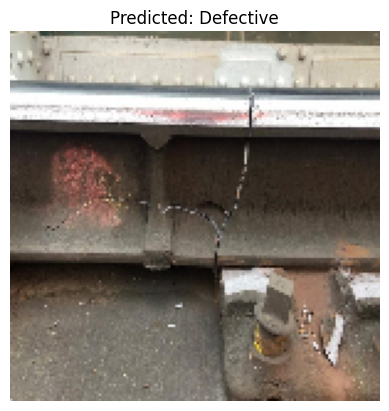

Prediction: Defective


In [21]:
image_path = '/content/drive/MyDrive/Rail Track Fault Detection/Broken-rail-3-900x600-c.jpg'
result = predict_image(model, image_path)
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


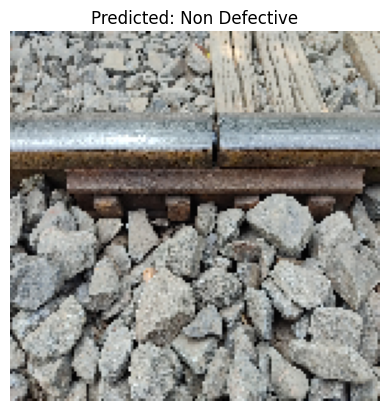

Prediction: Non Defective


In [22]:
image_path1 = '/content/drive/MyDrive/Rail Track Fault Detection/IMG_20201114_100358.jpg'
result = predict_image(model, image_path1)
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


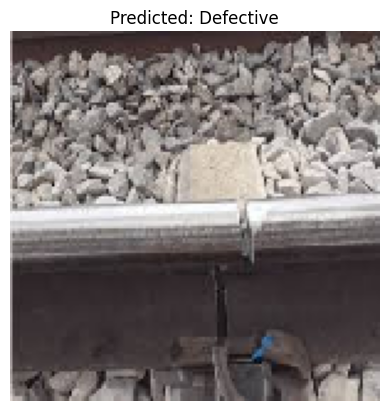

Prediction: Defective


In [23]:
image_path2 = '/content/drive/MyDrive/Rail Track Fault Detection/images.jpg'
result = predict_image(model, image_path2)
print("Prediction:", result)

## Saving the Trained Model

In [24]:
model.save('my_model.h5')